## Modules

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

C:\Users\vinicius\AppData\Local\Temp\ipykernel_7364\3524045577.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.0
Num GPUs: 1


## Funções Uteis

In [3]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [4]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [6]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [7]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [8]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [9]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


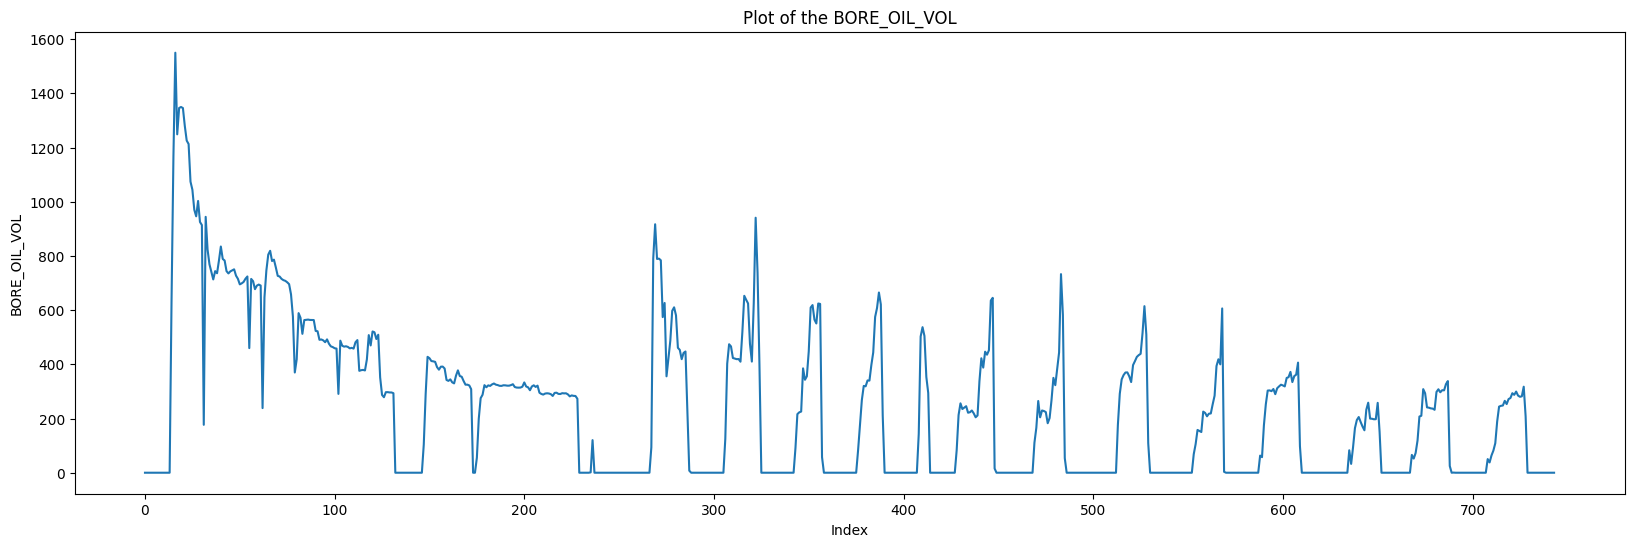

In [10]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [11]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [12]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


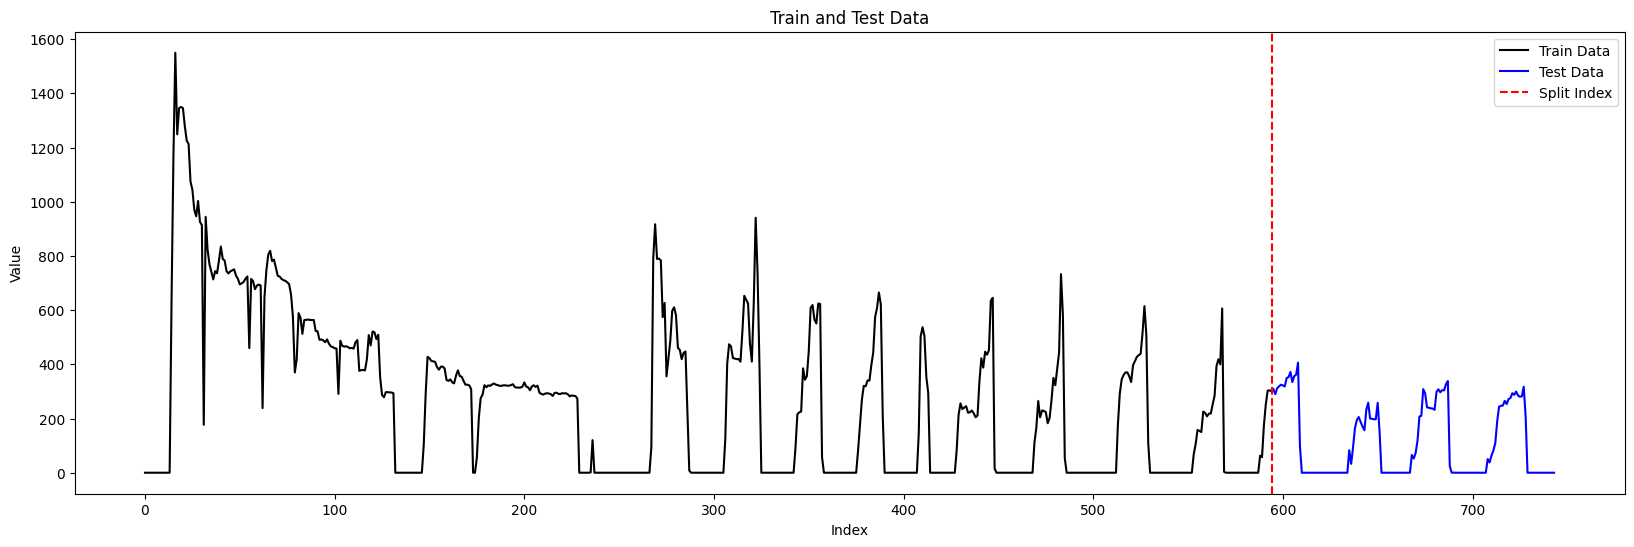

In [13]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [14]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [15]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [16]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [17]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [18]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [19]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [20]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [21]:
# pip install optuna
!pip install optuna-integration

In [22]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [23]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [24]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('batch_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [25]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2024-01-23 16:09:24,520] A new study created in memory with name: no-name-a5792d8b-c13e-45f6-8f8a-38a3791a52f3


In [26]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



INFO:tensorflow:Assets written to: ram://77908f57-490e-42e3-9273-080e419d5cdf/assets


INFO:tensorflow:Assets written to: ram://77908f57-490e-42e3-9273-080e419d5cdf/assets
[I 2024-01-23 16:22:38,474] Trial 0 finished with value: 0.016495371237397194 and parameters: {'window_size': 48, 'batch_size': 15, 'n_lstm_layers': 11, 'lstm_units': 33, 'learning_rate': 0.003080511633542446}. Best is trial 0 with value: 0.016495371237397194.


INFO:tensorflow:Assets written to: ram://c191404a-561c-4249-ad44-26426a011829/assets


INFO:tensorflow:Assets written to: ram://c191404a-561c-4249-ad44-26426a011829/assets
[I 2024-01-23 16:36:50,924] Trial 1 finished with value: 0.025440501049160957 and parameters: {'window_size': 27, 'batch_size': 12, 'n_lstm_layers': 15, 'lstm_units': 147, 'learning_rate': 0.008749236867576685}. Best is trial 0 with value: 0.016495371237397194.


INFO:tensorflow:Assets written to: ram://a08b9d45-94af-4314-898a-f448965e6009/assets


INFO:tensorflow:Assets written to: ram://a08b9d45-94af-4314-898a-f448965e6009/assets
[I 2024-01-23 16:51:59,990] Trial 2 finished with value: 0.015849091112613678 and parameters: {'window_size': 60, 'batch_size': 13, 'n_lstm_layers': 11, 'lstm_units': 141, 'learning_rate': 0.0033748149990163205}. Best is trial 2 with value: 0.015849091112613678.


INFO:tensorflow:Assets written to: ram://58731f2d-b43a-41f4-95e1-7e649e0921fe/assets


INFO:tensorflow:Assets written to: ram://58731f2d-b43a-41f4-95e1-7e649e0921fe/assets
[I 2024-01-23 16:57:10,458] Trial 3 finished with value: 0.003278235672041774 and parameters: {'window_size': 30, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 81, 'learning_rate': 0.004240612949811845}. Best is trial 3 with value: 0.003278235672041774.


INFO:tensorflow:Assets written to: ram://eb6c5704-7686-49e1-ba2e-c30ea0ba7859/assets


INFO:tensorflow:Assets written to: ram://eb6c5704-7686-49e1-ba2e-c30ea0ba7859/assets
[I 2024-01-23 17:03:41,981] Trial 4 finished with value: 0.002230830257758498 and parameters: {'window_size': 36, 'batch_size': 11, 'n_lstm_layers': 5, 'lstm_units': 113, 'learning_rate': 0.0024258421261069297}. Best is trial 4 with value: 0.002230830257758498.


INFO:tensorflow:Assets written to: ram://1c36758e-51c4-4db4-9a53-911dc8eac47f/assets


INFO:tensorflow:Assets written to: ram://1c36758e-51c4-4db4-9a53-911dc8eac47f/assets
[I 2024-01-23 17:11:42,629] Trial 5 finished with value: 0.020364969968795776 and parameters: {'window_size': 58, 'batch_size': 6, 'n_lstm_layers': 2, 'lstm_units': 194, 'learning_rate': 0.00012328123488117626}. Best is trial 4 with value: 0.002230830257758498.
[I 2024-01-23 17:11:46,498] Trial 6 pruned. 
[I 2024-01-23 17:11:52,940] Trial 7 pruned. 
[I 2024-01-23 17:11:56,929] Trial 8 pruned. 
[I 2024-01-23 17:12:11,626] Trial 9 pruned. 
[I 2024-01-23 17:12:39,551] Trial 10 pruned. 
[I 2024-01-23 17:12:46,465] Trial 11 pruned. 
[I 2024-01-23 17:12:54,461] Trial 12 pruned. 


INFO:tensorflow:Assets written to: ram://adcb29a0-c811-42af-bfc8-8dc8d804550d/assets


INFO:tensorflow:Assets written to: ram://adcb29a0-c811-42af-bfc8-8dc8d804550d/assets
[I 2024-01-23 17:21:13,239] Trial 13 finished with value: 0.002366395201534033 and parameters: {'window_size': 12, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 68, 'learning_rate': 0.0019355990321788161}. Best is trial 4 with value: 0.002230830257758498.
[I 2024-01-23 17:21:23,779] Trial 14 pruned. 


INFO:tensorflow:Assets written to: ram://1e3145fc-5440-4955-8420-d889430018ec/assets


INFO:tensorflow:Assets written to: ram://1e3145fc-5440-4955-8420-d889430018ec/assets
[I 2024-01-23 17:27:13,474] Trial 15 finished with value: 0.0027524083852767944 and parameters: {'window_size': 14, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 141, 'learning_rate': 0.0014753393724482786}. Best is trial 4 with value: 0.002230830257758498.
[I 2024-01-23 17:27:22,010] Trial 16 pruned. 
[I 2024-01-23 17:27:27,903] Trial 17 pruned. 
[I 2024-01-23 17:27:33,239] Trial 18 pruned. 


INFO:tensorflow:Assets written to: ram://781f4c96-a7fa-44ec-99b9-b5224a49db26/assets


INFO:tensorflow:Assets written to: ram://781f4c96-a7fa-44ec-99b9-b5224a49db26/assets
[I 2024-01-23 17:37:57,454] Trial 19 finished with value: 0.0016480609774589539 and parameters: {'window_size': 9, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 232, 'learning_rate': 0.002795982658842543}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 17:38:11,346] Trial 20 pruned. 
[I 2024-01-23 17:38:14,702] Trial 21 pruned. 


INFO:tensorflow:Assets written to: ram://4c3f3e88-90b5-4ddd-b6f2-b30270446666/assets


INFO:tensorflow:Assets written to: ram://4c3f3e88-90b5-4ddd-b6f2-b30270446666/assets
[I 2024-01-23 17:45:22,769] Trial 22 finished with value: 0.0020071505568921566 and parameters: {'window_size': 8, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 223, 'learning_rate': 0.001213686041444778}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 17:45:31,987] Trial 23 pruned. 
[I 2024-01-23 17:45:39,210] Trial 24 pruned. 
[I 2024-01-23 17:45:44,145] Trial 25 pruned. 
[I 2024-01-23 17:46:03,684] Trial 26 pruned. 
[I 2024-01-23 17:46:13,668] Trial 27 pruned. 


INFO:tensorflow:Assets written to: ram://e838f666-d822-4055-afe6-c5a1493ab566/assets


INFO:tensorflow:Assets written to: ram://e838f666-d822-4055-afe6-c5a1493ab566/assets
[I 2024-01-23 17:56:55,708] Trial 28 finished with value: 0.0019461974734440446 and parameters: {'window_size': 18, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 255, 'learning_rate': 0.0038041410473198837}. Best is trial 19 with value: 0.0016480609774589539.


INFO:tensorflow:Assets written to: ram://c8285c36-8386-44ff-b67f-a5a7b20c4559/assets


INFO:tensorflow:Assets written to: ram://c8285c36-8386-44ff-b67f-a5a7b20c4559/assets
[I 2024-01-23 18:05:10,361] Trial 29 finished with value: 0.001997005194425583 and parameters: {'window_size': 8, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 256, 'learning_rate': 0.004023031872490781}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 18:05:17,672] Trial 30 pruned. 


INFO:tensorflow:Assets written to: ram://4c6acfac-44d9-4c7e-8b7e-0cc15dd24362/assets


INFO:tensorflow:Assets written to: ram://4c6acfac-44d9-4c7e-8b7e-0cc15dd24362/assets
[I 2024-01-23 18:13:00,124] Trial 31 finished with value: 0.0016767632914707065 and parameters: {'window_size': 8, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 237, 'learning_rate': 0.0039150057318994525}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 18:13:04,040] Trial 32 pruned. 


INFO:tensorflow:Assets written to: ram://92e3b57e-e9a0-45d4-a77b-22fe2600cd19/assets


INFO:tensorflow:Assets written to: ram://92e3b57e-e9a0-45d4-a77b-22fe2600cd19/assets
[I 2024-01-23 18:17:36,329] Trial 33 finished with value: 0.002073433715850115 and parameters: {'window_size': 13, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 211, 'learning_rate': 0.003544607663529822}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 18:17:42,873] Trial 34 pruned. 
[I 2024-01-23 18:17:46,293] Trial 35 pruned. 
[I 2024-01-23 18:18:07,409] Trial 36 pruned. 
[I 2024-01-23 18:18:32,154] Trial 37 pruned. 
[I 2024-01-23 18:18:36,118] Trial 38 pruned. 
[I 2024-01-23 18:18:41,284] Trial 39 pruned. 
[I 2024-01-23 18:18:49,452] Trial 40 pruned. 


INFO:tensorflow:Assets written to: ram://d823d8d3-1d0c-4401-b863-389424202173/assets


INFO:tensorflow:Assets written to: ram://d823d8d3-1d0c-4401-b863-389424202173/assets
[I 2024-01-23 18:25:45,642] Trial 41 finished with value: 0.001991853816434741 and parameters: {'window_size': 8, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 220, 'learning_rate': 0.0028199599752645036}. Best is trial 19 with value: 0.0016480609774589539.


INFO:tensorflow:Assets written to: ram://c91ca1c3-0888-4526-8a00-b451675d6ec9/assets


INFO:tensorflow:Assets written to: ram://c91ca1c3-0888-4526-8a00-b451675d6ec9/assets
[I 2024-01-23 18:32:58,439] Trial 42 finished with value: 0.0022072899155318737 and parameters: {'window_size': 8, 'batch_size': 4, 'n_lstm_layers': 2, 'lstm_units': 246, 'learning_rate': 0.0030669965926604327}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 18:33:02,539] Trial 43 pruned. 
[I 2024-01-23 18:33:10,603] Trial 44 pruned. 
[I 2024-01-23 18:33:14,929] Trial 45 pruned. 
[I 2024-01-23 18:33:24,060] Trial 46 pruned. 
[I 2024-01-23 18:33:31,567] Trial 47 pruned. 


INFO:tensorflow:Assets written to: ram://5e4615bf-ab42-4115-96cb-e98a9be08b90/assets


INFO:tensorflow:Assets written to: ram://5e4615bf-ab42-4115-96cb-e98a9be08b90/assets
[I 2024-01-23 18:38:42,812] Trial 48 finished with value: 0.0017007217975333333 and parameters: {'window_size': 19, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 156, 'learning_rate': 0.003834070995377061}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 18:38:48,922] Trial 49 pruned. 
[I 2024-01-23 18:38:52,484] Trial 50 pruned. 


INFO:tensorflow:Assets written to: ram://2d556187-4e4e-4d29-ab5b-6eff3d4bcc95/assets


INFO:tensorflow:Assets written to: ram://2d556187-4e4e-4d29-ab5b-6eff3d4bcc95/assets
[I 2024-01-23 18:47:14,195] Trial 51 finished with value: 0.002357063116505742 and parameters: {'window_size': 31, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 247, 'learning_rate': 0.003884143490223052}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 18:47:17,816] Trial 52 pruned. 
[I 2024-01-23 18:47:25,948] Trial 53 pruned. 


INFO:tensorflow:Assets written to: ram://fd1e5ded-1d0a-4514-a40a-818ebd8b0bfb/assets


INFO:tensorflow:Assets written to: ram://fd1e5ded-1d0a-4514-a40a-818ebd8b0bfb/assets
[I 2024-01-23 18:57:17,024] Trial 54 finished with value: 0.0021675031166523695 and parameters: {'window_size': 18, 'batch_size': 3, 'n_lstm_layers': 2, 'lstm_units': 183, 'learning_rate': 0.002300707269025237}. Best is trial 19 with value: 0.0016480609774589539.


INFO:tensorflow:Assets written to: ram://9c1372be-2134-4ade-803f-cc184aa1c9d1/assets


INFO:tensorflow:Assets written to: ram://9c1372be-2134-4ade-803f-cc184aa1c9d1/assets
[I 2024-01-23 19:01:12,979] Trial 55 finished with value: 0.0020442709792405367 and parameters: {'window_size': 9, 'batch_size': 6, 'n_lstm_layers': 1, 'lstm_units': 101, 'learning_rate': 0.004961957878262497}. Best is trial 19 with value: 0.0016480609774589539.


INFO:tensorflow:Assets written to: ram://6d1e63a6-f80e-47a3-be28-f39a6a12a523/assets


INFO:tensorflow:Assets written to: ram://6d1e63a6-f80e-47a3-be28-f39a6a12a523/assets
[I 2024-01-23 19:03:35,125] Trial 56 finished with value: 0.0033398186787962914 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 4, 'lstm_units': 256, 'learning_rate': 0.00591460207373268}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 19:03:46,754] Trial 57 pruned. 
[I 2024-01-23 19:03:50,567] Trial 58 pruned. 
[I 2024-01-23 19:03:55,568] Trial 59 pruned. 
[I 2024-01-23 19:03:59,653] Trial 60 pruned. 
[I 2024-01-23 19:04:03,631] Trial 61 pruned. 
[I 2024-01-23 19:04:07,238] Trial 62 pruned. 
[I 2024-01-23 19:04:11,389] Trial 63 pruned. 
[I 2024-01-23 19:04:19,069] Trial 64 pruned. 
[I 2024-01-23 19:04:22,823] Trial 65 pruned. 
[I 2024-01-23 19:04:25,999] Trial 66 pruned. 
[I 2024-01-23 19:04:31,622] Trial 67 pruned. 
[I 2024-01-23 19:04:49,113] Trial 68 pruned. 
[I 2024-01-23 19:04:56,497] Trial 69 pruned. 
[I 2024-01-23 19:05:05,356] Trial 70 pruned. 
[I 2024-

INFO:tensorflow:Assets written to: ram://d5944426-c908-4409-8cfd-6badca67e992/assets


INFO:tensorflow:Assets written to: ram://d5944426-c908-4409-8cfd-6badca67e992/assets
[I 2024-01-23 19:11:59,882] Trial 72 finished with value: 0.0018082851311191916 and parameters: {'window_size': 8, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 78, 'learning_rate': 0.005579279446946744}. Best is trial 19 with value: 0.0016480609774589539.
[I 2024-01-23 19:12:04,661] Trial 73 pruned. 
[I 2024-01-23 19:12:08,390] Trial 74 pruned. 


INFO:tensorflow:Assets written to: ram://ea0f3235-8612-4daa-9b14-edc4b67d37f6/assets


INFO:tensorflow:Assets written to: ram://ea0f3235-8612-4daa-9b14-edc4b67d37f6/assets
[I 2024-01-23 19:19:48,852] Trial 75 finished with value: 0.001504303771071136 and parameters: {'window_size': 7, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 242, 'learning_rate': 0.007263951513373434}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 19:20:04,653] Trial 76 pruned. 
[I 2024-01-23 19:20:09,218] Trial 77 pruned. 
[I 2024-01-23 19:20:21,614] Trial 78 pruned. 
[I 2024-01-23 19:20:24,291] Trial 79 pruned. 
[I 2024-01-23 19:20:30,582] Trial 80 pruned. 


INFO:tensorflow:Assets written to: ram://36cf1bf9-52a1-4acc-a3d9-203e03a7e5c6/assets


INFO:tensorflow:Assets written to: ram://36cf1bf9-52a1-4acc-a3d9-203e03a7e5c6/assets
[I 2024-01-23 19:28:12,631] Trial 81 finished with value: 0.0015593188581988215 and parameters: {'window_size': 7, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 243, 'learning_rate': 0.004348212501947115}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://f54afa6d-bfa9-4ed1-bfc4-f6a5222aa810/assets


INFO:tensorflow:Assets written to: ram://f54afa6d-bfa9-4ed1-bfc4-f6a5222aa810/assets
[I 2024-01-23 19:36:41,122] Trial 82 finished with value: 0.0023028801660984755 and parameters: {'window_size': 7, 'batch_size': 3, 'n_lstm_layers': 2, 'lstm_units': 244, 'learning_rate': 0.0036564484182701256}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 19:36:45,003] Trial 83 pruned. 


INFO:tensorflow:Assets written to: ram://5b90c8ef-8b6e-472e-b75d-c3a184794656/assets


INFO:tensorflow:Assets written to: ram://5b90c8ef-8b6e-472e-b75d-c3a184794656/assets
[I 2024-01-23 19:42:09,204] Trial 84 finished with value: 0.0022494669537991285 and parameters: {'window_size': 2, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.003112087072777}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 19:42:13,983] Trial 85 pruned. 
[I 2024-01-23 19:42:16,813] Trial 86 pruned. 
[I 2024-01-23 19:42:19,878] Trial 87 pruned. 
[I 2024-01-23 19:42:28,061] Trial 88 pruned. 
[I 2024-01-23 19:42:30,574] Trial 89 pruned. 
[I 2024-01-23 19:42:34,863] Trial 90 pruned. 
[I 2024-01-23 19:42:38,061] Trial 91 pruned. 
[I 2024-01-23 19:42:42,335] Trial 92 pruned. 
[I 2024-01-23 19:42:45,430] Trial 93 pruned. 
[I 2024-01-23 19:42:49,255] Trial 94 pruned. 
[I 2024-01-23 19:42:51,772] Trial 95 pruned. 
[I 2024-01-23 19:42:56,098] Trial 96 pruned. 
[I 2024-01-23 19:42:59,773] Trial 97 pruned. 
[I 2024-01-23 19:43:06,810] Trial 98 pruned. 
[I 2024-01-2

INFO:tensorflow:Assets written to: ram://5bf7c8da-3e41-4f7f-afbd-52816b3ea8f9/assets


INFO:tensorflow:Assets written to: ram://5bf7c8da-3e41-4f7f-afbd-52816b3ea8f9/assets
[I 2024-01-23 19:52:11,218] Trial 105 finished with value: 0.0017958794487640262 and parameters: {'window_size': 6, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 79, 'learning_rate': 0.005745514129386467}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 19:52:14,404] Trial 106 pruned. 
[I 2024-01-23 19:52:20,737] Trial 107 pruned. 
[I 2024-01-23 19:52:24,095] Trial 108 pruned. 
[I 2024-01-23 19:52:30,657] Trial 109 pruned. 
[I 2024-01-23 19:52:34,650] Trial 110 pruned. 
[I 2024-01-23 19:52:38,864] Trial 111 pruned. 
[I 2024-01-23 19:52:41,382] Trial 112 pruned. 


INFO:tensorflow:Assets written to: ram://1914cbd6-9127-4a01-82ec-3af5308222e0/assets


INFO:tensorflow:Assets written to: ram://1914cbd6-9127-4a01-82ec-3af5308222e0/assets
[I 2024-01-23 19:57:00,336] Trial 113 finished with value: 0.0017202263697981834 and parameters: {'window_size': 6, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 127, 'learning_rate': 0.004852444193618241}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 19:57:04,230] Trial 114 pruned. 
[I 2024-01-23 19:57:07,034] Trial 115 pruned. 
[I 2024-01-23 19:57:11,400] Trial 116 pruned. 
[I 2024-01-23 19:57:32,738] Trial 117 pruned. 
[I 2024-01-23 19:57:40,139] Trial 118 pruned. 
[I 2024-01-23 19:57:44,694] Trial 119 pruned. 


INFO:tensorflow:Assets written to: ram://aa551b07-9953-4321-9778-eb56a134e63c/assets


INFO:tensorflow:Assets written to: ram://aa551b07-9953-4321-9778-eb56a134e63c/assets
[I 2024-01-23 20:15:07,764] Trial 120 finished with value: 0.00691002793610096 and parameters: {'window_size': 29, 'batch_size': 2, 'n_lstm_layers': 2, 'lstm_units': 64, 'learning_rate': 0.006605327568652493}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 20:15:10,142] Trial 121 pruned. 
[I 2024-01-23 20:15:13,475] Trial 122 pruned. 
[I 2024-01-23 20:15:16,995] Trial 123 pruned. 
[I 2024-01-23 20:15:20,019] Trial 124 pruned. 
[I 2024-01-23 20:15:22,509] Trial 125 pruned. 
[I 2024-01-23 20:15:25,814] Trial 126 pruned. 
[I 2024-01-23 20:15:34,491] Trial 127 pruned. 
[I 2024-01-23 20:15:36,968] Trial 128 pruned. 
[I 2024-01-23 20:15:39,586] Trial 129 pruned. 
[I 2024-01-23 20:15:50,203] Trial 130 pruned. 
[I 2024-01-23 20:15:54,399] Trial 131 pruned. 


INFO:tensorflow:Assets written to: ram://3062af9a-3037-4fae-a64a-3da161809abf/assets


INFO:tensorflow:Assets written to: ram://3062af9a-3037-4fae-a64a-3da161809abf/assets
[I 2024-01-23 20:21:27,512] Trial 132 finished with value: 0.002495295600965619 and parameters: {'window_size': 17, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 233, 'learning_rate': 0.0034953287236298594}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 20:21:31,237] Trial 133 pruned. 
[I 2024-01-23 20:21:35,553] Trial 134 pruned. 
[I 2024-01-23 20:21:38,499] Trial 135 pruned. 
[I 2024-01-23 20:21:41,913] Trial 136 pruned. 


INFO:tensorflow:Assets written to: ram://59afb29e-ea54-423f-8f2b-0dc2546d913f/assets


INFO:tensorflow:Assets written to: ram://59afb29e-ea54-423f-8f2b-0dc2546d913f/assets
[I 2024-01-23 20:25:08,400] Trial 137 finished with value: 0.0032976146321743727 and parameters: {'window_size': 22, 'batch_size': 6, 'n_lstm_layers': 1, 'lstm_units': 112, 'learning_rate': 0.00361009791643917}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 20:25:12,057] Trial 138 pruned. 


INFO:tensorflow:Assets written to: ram://5ef336e4-f05c-40b2-ab53-64e1e14eb7d1/assets


INFO:tensorflow:Assets written to: ram://5ef336e4-f05c-40b2-ab53-64e1e14eb7d1/assets
[I 2024-01-23 20:31:43,975] Trial 139 finished with value: 0.001812513219192624 and parameters: {'window_size': 7, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 182, 'learning_rate': 0.002746757338137952}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 20:31:47,109] Trial 140 pruned. 
[I 2024-01-23 20:31:50,134] Trial 141 pruned. 
[I 2024-01-23 20:31:53,804] Trial 142 pruned. 


INFO:tensorflow:Assets written to: ram://930e864e-6f75-45c3-bf37-96e4bd144e1e/assets


INFO:tensorflow:Assets written to: ram://930e864e-6f75-45c3-bf37-96e4bd144e1e/assets
[I 2024-01-23 20:38:23,716] Trial 143 finished with value: 0.0015532823745161295 and parameters: {'window_size': 7, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 185, 'learning_rate': 0.002593442078096927}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 20:38:27,287] Trial 144 pruned. 
[I 2024-01-23 20:38:30,431] Trial 145 pruned. 
[I 2024-01-23 20:38:34,551] Trial 146 pruned. 
[I 2024-01-23 20:38:37,531] Trial 147 pruned. 
[I 2024-01-23 20:38:39,856] Trial 148 pruned. 
[I 2024-01-23 20:38:43,318] Trial 149 pruned. 
[I 2024-01-23 20:38:48,076] Trial 150 pruned. 
[I 2024-01-23 20:38:51,798] Trial 151 pruned. 
[I 2024-01-23 20:38:55,398] Trial 152 pruned. 
[I 2024-01-23 20:38:58,655] Trial 153 pruned. 
[I 2024-01-23 20:39:03,001] Trial 154 pruned. 
[I 2024-01-23 20:39:04,958] Trial 155 pruned. 
[I 2024-01-23 20:39:09,010] Trial 156 pruned. 
[I 2024-01-23 20:39:12,360] Trial 157 pru

INFO:tensorflow:Assets written to: ram://962815d8-2511-4d40-a332-a00628be6f24/assets


INFO:tensorflow:Assets written to: ram://962815d8-2511-4d40-a332-a00628be6f24/assets
[I 2024-01-23 20:46:25,932] Trial 159 finished with value: 0.0015933146933093667 and parameters: {'window_size': 9, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 185, 'learning_rate': 0.0037347566202719676}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://31377de1-06a4-47e5-9c35-3d596678c9fe/assets


INFO:tensorflow:Assets written to: ram://31377de1-06a4-47e5-9c35-3d596678c9fe/assets
[I 2024-01-23 20:53:34,150] Trial 160 finished with value: 0.0016546130646020174 and parameters: {'window_size': 9, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 185, 'learning_rate': 0.005138349071390828}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://c382051f-b260-40fb-9015-c02f47a14ac3/assets


INFO:tensorflow:Assets written to: ram://c382051f-b260-40fb-9015-c02f47a14ac3/assets
[I 2024-01-23 21:00:42,256] Trial 161 finished with value: 0.0018695497419685125 and parameters: {'window_size': 9, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 186, 'learning_rate': 0.005044264942909428}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 21:00:44,894] Trial 162 pruned. 
[I 2024-01-23 21:00:48,023] Trial 163 pruned. 


INFO:tensorflow:Assets written to: ram://ddaefa04-6113-46e5-9f62-0685e935d69c/assets


INFO:tensorflow:Assets written to: ram://ddaefa04-6113-46e5-9f62-0685e935d69c/assets
[I 2024-01-23 21:10:28,343] Trial 164 finished with value: 0.0015884876484051347 and parameters: {'window_size': 9, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 184, 'learning_rate': 0.004728030955959187}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 21:10:32,580] Trial 165 pruned. 
[I 2024-01-23 21:10:38,975] Trial 166 pruned. 
[I 2024-01-23 21:10:43,505] Trial 167 pruned. 
[I 2024-01-23 21:11:00,988] Trial 168 pruned. 


INFO:tensorflow:Assets written to: ram://5807c82e-ba82-4544-9b4b-53822ff2827e/assets


INFO:tensorflow:Assets written to: ram://5807c82e-ba82-4544-9b4b-53822ff2827e/assets
[I 2024-01-23 21:25:28,988] Trial 169 finished with value: 0.0023308307863771915 and parameters: {'window_size': 9, 'batch_size': 2, 'n_lstm_layers': 2, 'lstm_units': 193, 'learning_rate': 0.004584934657808444}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://8262b435-fdcf-4ab8-bbb0-a7a1fa555e0b/assets


INFO:tensorflow:Assets written to: ram://8262b435-fdcf-4ab8-bbb0-a7a1fa555e0b/assets
[I 2024-01-23 21:33:32,483] Trial 170 finished with value: 0.0018238566117361188 and parameters: {'window_size': 38, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 180, 'learning_rate': 0.004393995970454126}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://6349ead7-8928-4499-a088-41e8c8cd9679/assets


INFO:tensorflow:Assets written to: ram://6349ead7-8928-4499-a088-41e8c8cd9679/assets
[I 2024-01-23 21:42:52,122] Trial 171 finished with value: 0.011244515888392925 and parameters: {'window_size': 45, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 188, 'learning_rate': 0.004323373731773649}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://c95db634-9f55-4821-bd2e-99389dfc2ac7/assets


INFO:tensorflow:Assets written to: ram://c95db634-9f55-4821-bd2e-99389dfc2ac7/assets
[I 2024-01-23 21:50:50,785] Trial 172 finished with value: 0.002338286954909563 and parameters: {'window_size': 32, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 174, 'learning_rate': 0.004509565557660175}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 21:50:54,357] Trial 173 pruned. 
[I 2024-01-23 21:50:59,526] Trial 174 pruned. 
[I 2024-01-23 21:51:02,236] Trial 175 pruned. 
[I 2024-01-23 21:51:07,548] Trial 176 pruned. 
[I 2024-01-23 21:51:10,487] Trial 177 pruned. 
[I 2024-01-23 21:51:15,476] Trial 178 pruned. 


INFO:tensorflow:Assets written to: ram://0d956f69-0db6-400e-87a1-6f64b629e458/assets


INFO:tensorflow:Assets written to: ram://0d956f69-0db6-400e-87a1-6f64b629e458/assets
[I 2024-01-23 21:59:38,253] Trial 179 finished with value: 0.008626414462924004 and parameters: {'window_size': 38, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 162, 'learning_rate': 0.004280498974644879}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 21:59:41,787] Trial 180 pruned. 
[I 2024-01-23 21:59:44,444] Trial 181 pruned. 
[I 2024-01-23 21:59:47,374] Trial 182 pruned. 
[I 2024-01-23 21:59:51,546] Trial 183 pruned. 


INFO:tensorflow:Assets written to: ram://2578a80e-b2d2-4859-81b5-12a8d63dc801/assets


INFO:tensorflow:Assets written to: ram://2578a80e-b2d2-4859-81b5-12a8d63dc801/assets
[I 2024-01-23 22:16:39,763] Trial 184 finished with value: 0.0018040698487311602 and parameters: {'window_size': 6, 'batch_size': 1, 'n_lstm_layers': 1, 'lstm_units': 180, 'learning_rate': 0.0032443828911676263}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 22:16:43,597] Trial 185 pruned. 
[I 2024-01-23 22:16:49,236] Trial 186 pruned. 
[I 2024-01-23 22:16:53,147] Trial 187 pruned. 
[I 2024-01-23 22:16:56,035] Trial 188 pruned. 
[I 2024-01-23 22:17:01,094] Trial 189 pruned. 
[I 2024-01-23 22:17:04,015] Trial 190 pruned. 


INFO:tensorflow:Assets written to: ram://43059e3c-ede3-45b1-a545-ca360aa42247/assets


INFO:tensorflow:Assets written to: ram://43059e3c-ede3-45b1-a545-ca360aa42247/assets
[I 2024-01-23 22:24:51,557] Trial 191 finished with value: 0.00177616230212152 and parameters: {'window_size': 9, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 234, 'learning_rate': 0.004936985502436855}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://79566e08-b1a0-4d25-a2c8-7b5acbd2e497/assets


INFO:tensorflow:Assets written to: ram://79566e08-b1a0-4d25-a2c8-7b5acbd2e497/assets
[I 2024-01-23 22:29:49,768] Trial 192 finished with value: 0.001762971980497241 and parameters: {'window_size': 9, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 180, 'learning_rate': 0.0054290971211968}. Best is trial 75 with value: 0.001504303771071136.


INFO:tensorflow:Assets written to: ram://28159f5a-86b9-4c3d-a814-5ccc6c888936/assets


INFO:tensorflow:Assets written to: ram://28159f5a-86b9-4c3d-a814-5ccc6c888936/assets
[I 2024-01-23 22:35:42,513] Trial 193 finished with value: 0.0017752050189301372 and parameters: {'window_size': 9, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 234, 'learning_rate': 0.005437602364410192}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 22:35:44,875] Trial 194 pruned. 
[I 2024-01-23 22:35:48,423] Trial 195 pruned. 
[I 2024-01-23 22:35:52,372] Trial 196 pruned. 
[I 2024-01-23 22:35:56,105] Trial 197 pruned. 
[I 2024-01-23 22:35:58,929] Trial 198 pruned. 
[I 2024-01-23 22:36:02,792] Trial 199 pruned. 


INFO:tensorflow:Assets written to: ram://ef66ed76-a7b9-44a3-9c4b-1fdf99d5456b/assets


INFO:tensorflow:Assets written to: ram://ef66ed76-a7b9-44a3-9c4b-1fdf99d5456b/assets
[I 2024-01-23 22:41:45,109] Trial 200 finished with value: 0.0016573527827858925 and parameters: {'window_size': 9, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 242, 'learning_rate': 0.0055885448074595185}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 22:41:48,434] Trial 201 pruned. 
[I 2024-01-23 22:41:50,883] Trial 202 pruned. 


INFO:tensorflow:Assets written to: ram://abcc1a1d-e368-4c92-b5f2-1ac1e00ac5f7/assets


INFO:tensorflow:Assets written to: ram://abcc1a1d-e368-4c92-b5f2-1ac1e00ac5f7/assets
[I 2024-01-23 22:45:44,849] Trial 203 finished with value: 0.0020354934968054295 and parameters: {'window_size': 8, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 243, 'learning_rate': 0.005121484235311641}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 22:45:48,083] Trial 204 pruned. 
[I 2024-01-23 22:45:51,072] Trial 205 pruned. 
[I 2024-01-23 22:45:53,934] Trial 206 pruned. 
[I 2024-01-23 22:45:57,180] Trial 207 pruned. 
[I 2024-01-23 22:46:00,162] Trial 208 pruned. 
[I 2024-01-23 22:46:03,359] Trial 209 pruned. 
[I 2024-01-23 22:46:14,628] Trial 210 pruned. 
[I 2024-01-23 22:46:17,364] Trial 211 pruned. 
[I 2024-01-23 22:46:20,230] Trial 212 pruned. 
[I 2024-01-23 22:46:22,986] Trial 213 pruned. 
[I 2024-01-23 22:46:26,991] Trial 214 pruned. 
[I 2024-01-23 22:46:29,663] Trial 215 pruned. 
[I 2024-01-23 22:46:33,970] Trial 216 pruned. 
[I 2024-01-23 22:46:41,482] Trial 217 pru

INFO:tensorflow:Assets written to: ram://0cd862fb-c2c3-4d77-a648-605df865f4e0/assets


INFO:tensorflow:Assets written to: ram://0cd862fb-c2c3-4d77-a648-605df865f4e0/assets
[I 2024-01-23 22:57:25,801] Trial 221 finished with value: 0.0015828770119696856 and parameters: {'window_size': 6, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 236, 'learning_rate': 0.004145532853729188}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 22:57:28,630] Trial 222 pruned. 
[I 2024-01-23 22:57:31,780] Trial 223 pruned. 
[I 2024-01-23 22:57:36,181] Trial 224 pruned. 
[I 2024-01-23 22:57:38,951] Trial 225 pruned. 
[I 2024-01-23 22:57:43,365] Trial 226 pruned. 
[I 2024-01-23 22:57:54,893] Trial 227 pruned. 
[I 2024-01-23 22:57:57,235] Trial 228 pruned. 


INFO:tensorflow:Assets written to: ram://4b38a8cd-4de5-44aa-b49f-994a7309a641/assets


INFO:tensorflow:Assets written to: ram://4b38a8cd-4de5-44aa-b49f-994a7309a641/assets
[I 2024-01-23 23:12:25,578] Trial 229 finished with value: 0.0022376938723027706 and parameters: {'window_size': 9, 'batch_size': 2, 'n_lstm_layers': 2, 'lstm_units': 159, 'learning_rate': 0.005208444639791119}. Best is trial 75 with value: 0.001504303771071136.
[I 2024-01-23 23:12:28,842] Trial 230 pruned. 
[I 2024-01-23 23:12:32,270] Trial 231 pruned. 
[I 2024-01-23 23:12:34,919] Trial 232 pruned. 


INFO:tensorflow:Assets written to: ram://e0c0417f-6886-4fc2-903b-5541cfe8c774/assets


INFO:tensorflow:Assets written to: ram://e0c0417f-6886-4fc2-903b-5541cfe8c774/assets
[I 2024-01-23 23:22:54,397] Trial 233 finished with value: 0.0014911824837327003 and parameters: {'window_size': 9, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 244, 'learning_rate': 0.004234189335724961}. Best is trial 233 with value: 0.0014911824837327003.
[I 2024-01-23 23:22:58,328] Trial 234 pruned. 
[I 2024-01-23 23:23:01,566] Trial 235 pruned. 
[I 2024-01-23 23:23:04,582] Trial 236 pruned. 
[I 2024-01-23 23:23:07,905] Trial 237 pruned. 
[I 2024-01-23 23:23:11,722] Trial 238 pruned. 
[I 2024-01-23 23:23:18,552] Trial 239 pruned. 
[I 2024-01-23 23:23:21,748] Trial 240 pruned. 
[I 2024-01-23 23:23:24,982] Trial 241 pruned. 
[I 2024-01-23 23:23:28,466] Trial 242 pruned. 
[I 2024-01-23 23:23:31,304] Trial 243 pruned. 
[I 2024-01-23 23:23:34,410] Trial 244 pruned. 
[I 2024-01-23 23:23:55,544] Trial 245 pruned. 
[I 2024-01-23 23:24:00,207] Trial 246 pruned. 
[I 2024-01-23 23:24:02,711] Trial 247 p

INFO:tensorflow:Assets written to: ram://47c3be01-d00a-4219-961c-617e1a2278ee/assets


INFO:tensorflow:Assets written to: ram://47c3be01-d00a-4219-961c-617e1a2278ee/assets
[I 2024-01-23 23:32:49,781] Trial 248 finished with value: 0.003374712774530053 and parameters: {'window_size': 38, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 237, 'learning_rate': 0.002792419142420831}. Best is trial 233 with value: 0.0014911824837327003.
[I 2024-01-23 23:32:52,901] Trial 249 pruned. 


In [27]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 9, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 244, 'learning_rate': 0.004234189335724961}
Best Validation Loss: 0.0014911824837327003


In [28]:
study.best_params['n_lstm_layers']

1

In [29]:
study.best_trial.number

233

In [30]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['batch_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [31]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [32]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.001798800479049402
Test MSE: 0.0017702498822757832


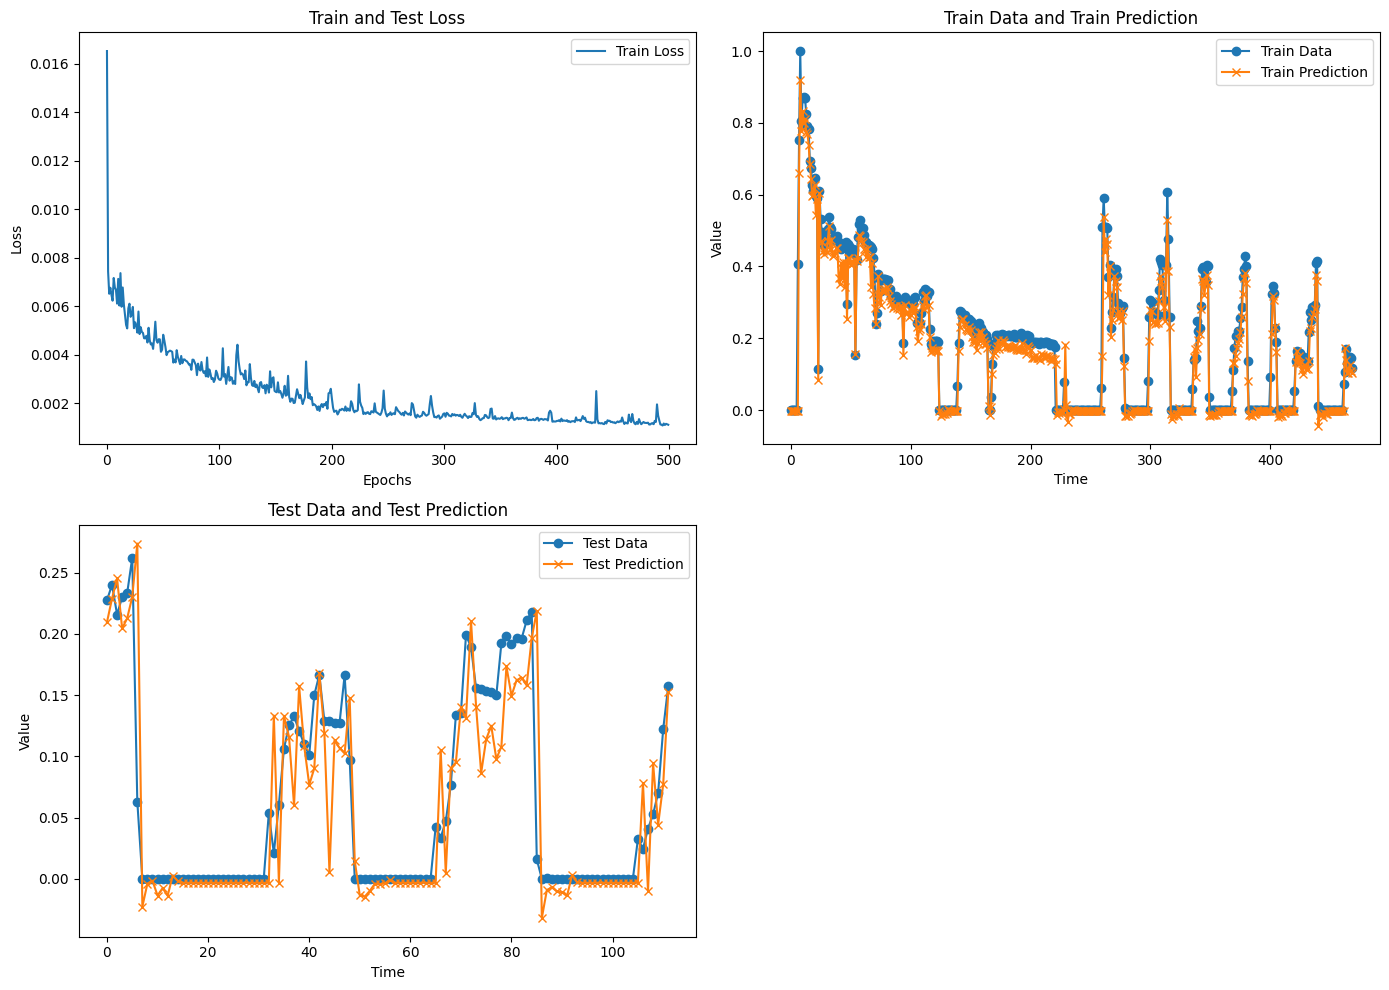

In [33]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

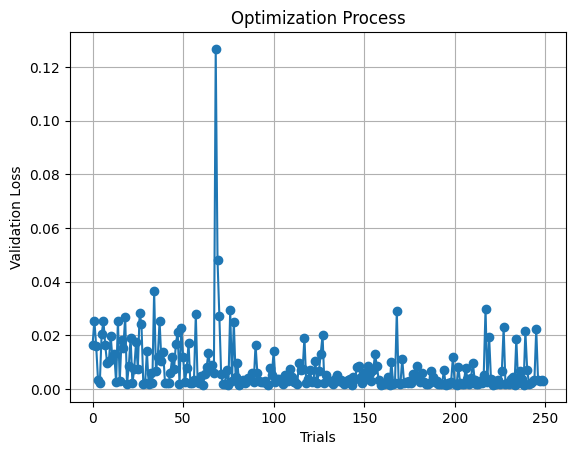

In [34]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

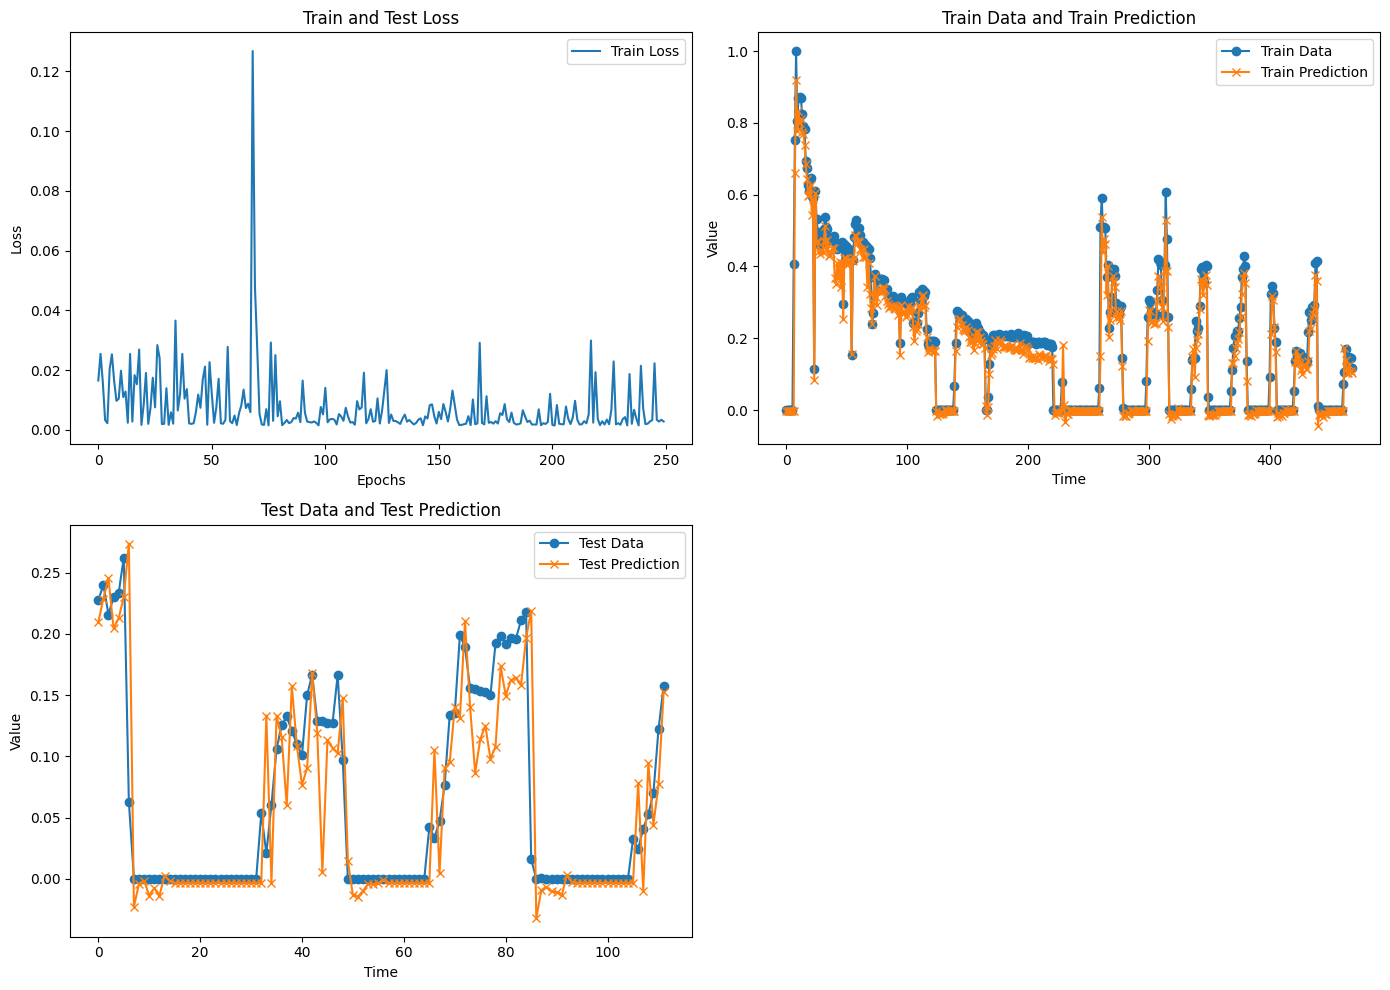

In [35]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

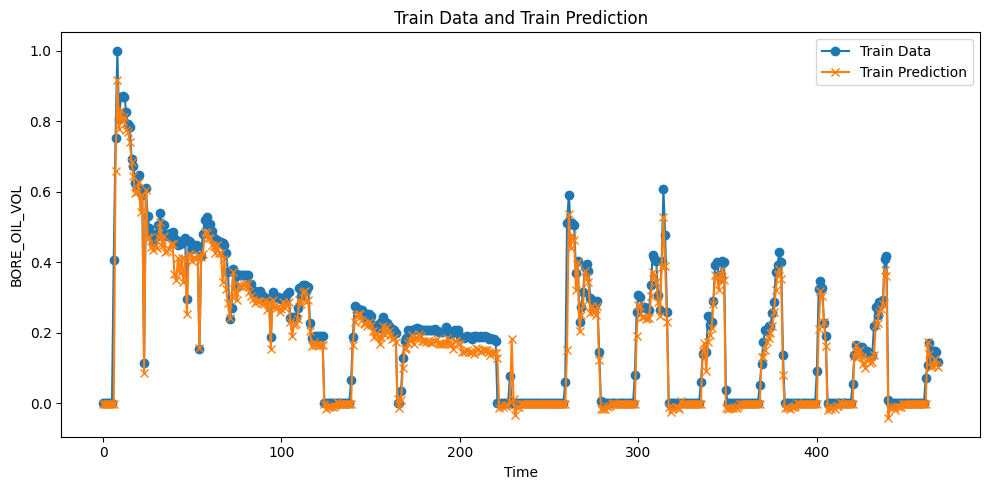

In [50]:
plt.figure(figsize=(10,5))
# Plot Test Data and Test Prediction
plt.plot(y_train, label='Train Data', marker='o')
plt.plot(y_train_pred_LSTM, label='Train Prediction', marker='x')
plt.xlabel('Time')
plt.ylabel('BORE_OIL_VOL')
plt.title('Train Data and Train Prediction')
plt.legend()

plt.tight_layout()
plt.show()

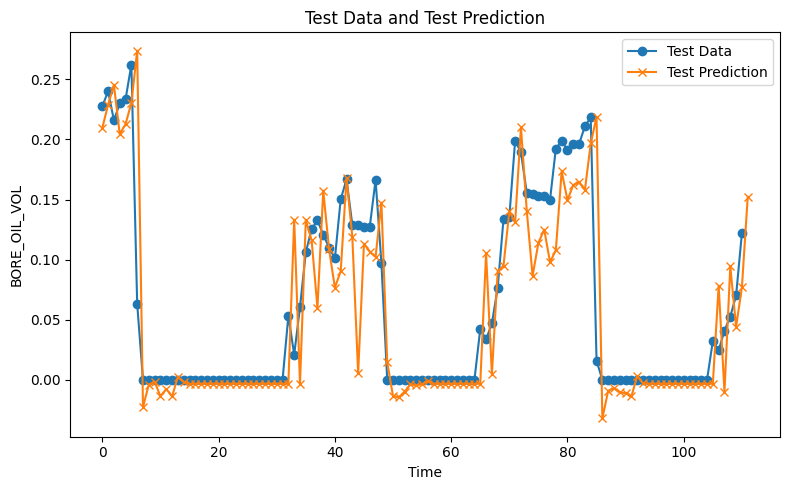

In [51]:
plt.figure(figsize=(8,5))
# Plot Test Data and Test Prediction
plt.plot(y_test[:-1], label='Test Data', marker='o')
plt.plot(y_test_pred_LSTM, label='Test Prediction', marker='x')
plt.xlabel('Time')
plt.ylabel('BORE_OIL_VOL')
plt.title('Test Data and Test Prediction')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [38]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [39]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [40]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [41]:
# from keras.utils.vis_utils import plot_model


In [42]:
# plot_model(model_LSTM)

In [43]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [44]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [45]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.005443412828446972
Test MSE: 0.0016596540625423088


In [46]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [47]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.001799   0.00177
1  Baseline   0.005443   0.00166


In [48]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [49]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 48, 'batch_size': 15, 'n_lstm_layers': 11, 'lstm_units': 33, 'learning_rate': 0.003080511633542446}
Trial 2: {'window_size': 27, 'batch_size': 12, 'n_lstm_layers': 15, 'lstm_units': 147, 'learning_rate': 0.008749236867576685}
Trial 3: {'window_size': 60, 'batch_size': 13, 'n_lstm_layers': 11, 'lstm_units': 141, 'learning_rate': 0.0033748149990163205}
Trial 4: {'window_size': 30, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 81, 'learning_rate': 0.004240612949811845}
Trial 5: {'window_size': 36, 'batch_size': 11, 'n_lstm_layers': 5, 'lstm_units': 113, 'learning_rate': 0.0024258421261069297}
Trial 6: {'window_size': 58, 'batch_size': 6, 'n_lstm_layers': 2, 'lstm_units': 194, 'learning_rate': 0.00012328123488117626}
Trial 7: {'window_size': 29, 'batch_size': 13, 'n_lstm_layers': 3, 'lstm_units': 89, 'learning_rate': 0.008996247142858198}
Trial 8: {'window_size': 23, 'batch_size': 8, 'n_lstm_layers': 5, 'lstm_units': 1